In [1]:
import IPython.display as ipd
import sys
sys.path.append('..')
import features
import util
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib notebook
import numpy as np
import pandas as pd
from time import time
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
import pedalboard as pdb

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [3]:
DATA_PATH = "/home/alexandre/dataset/"
AUDIO_PATH = "/home/alexandre/Music/classifier_presentation/"
CLASSES = ['Dry', 'Feedback Delay', 'Slapback Delay', 'Reverb', 'Chorus', 'Flanger', 'Phaser',
           'Tremolo', 'Vibrato', 'Distortion', 'Overdrive']

In [4]:
def _classes2color(char: str):
    match char:
        case 0:
            return 'dimgrey'
        case 1:
            return 'lightcoral'
        case 2:
            return 'lightsalmon'
        case 3:
            return 'chocolate'
        case 4:
            return 'khaki'
        case 5:
            return 'darkseagreen'
        case 6:
            return 'mediumaquamarine'
        case 7:
            return 'skyblue'
        case 8:
            return 'mediumpurple'
        case 9:
            return 'violet'
        case 10:
            return 'crimson'

In [5]:
def color_vector(classes):
    colors=[]
    for cls in classes:
        colors.append(_classes2color(cls))
    return colors

def label_clean(label):
    label = label.split('{')[-1]
    label = label.split('}')[0]
    return int(label)

def label_vector(classes):
    labels=[]
    for cls in classes:
        labels.append(util.class_number2idmt_fx(label_clean(cls)))
    return labels

# Classifiers for Guitar FX recognition
### March 2022

## The dataset

__IDMT-SMT-Audio Effects__ from the Fraunhofer institute, published along with Stein _et al._, Automatic Detection of Audio Effects in Guitar and Bass recordings, AES 2010.

_Note:_ To have the same number of samples in each classes, the classes `EQ` and `NoFx` are fused into one.

In [6]:
print("Original audio:")
ipd.display(ipd.Audio(AUDIO_PATH + 'dry.wav'))
print("Chorus:")
ipd.display(ipd.Audio(AUDIO_PATH + 'chorus.wav'))
print("Distortion:")
ipd.display(ipd.Audio(AUDIO_PATH + 'distortion.wav'))
print("Equalizer:")
ipd.display(ipd.Audio(AUDIO_PATH + 'eq.wav'))
print("Feedback Delay:")
ipd.display(ipd.Audio(AUDIO_PATH + 'fdback_delay.wav'))
print("Flanger:")
ipd.display(ipd.Audio(AUDIO_PATH + 'flanger.wav'))
print("Overdrive:")
ipd.display(ipd.Audio(AUDIO_PATH + 'overdrive.wav'))
print("Phaser:")
ipd.display(ipd.Audio(AUDIO_PATH + 'phaser.wav'))
print("Reverb:")
ipd.display(ipd.Audio(AUDIO_PATH + 'reverb.wav'))
print("Slapback Delay:")
ipd.display(ipd.Audio(AUDIO_PATH + 'slpback_delay.wav'))
print("Tremolo:")
ipd.display(ipd.Audio(AUDIO_PATH + 'tremolo.wav'))
print("Vibrato:")
ipd.display(ipd.Audio(AUDIO_PATH + 'vibrato.wav'))

Original audio:


Chorus:


Distortion:


Equalizer:


Feedback Delay:


Flanger:


Overdrive:


Phaser:


Reverb:


Slapback Delay:


Tremolo:


Vibrato:


## Extracted features

From the Short-Time Fourier Transform, several spectral features are extracted.

References:

- [1] Stein _et al._, Automatic Detection of audio effects in Guitar and Bass Recordings, AES 2010;
- [2] Geoffroy Peeters, Technical report of the CUIDADO Project, 2003;
- [3] Tae Hong Park, Towards automatic musical instrument timbre recognition, PhD Thesis 2004.

### Spectral Centroid, Spread, Skewness and Kurtosis

The spectrum is considered as a probability distribution which values are the frequencies and the probabilities are the normalized amplitudes [2].

1. Centroid: Barycenter of the spectrum.
$$ \mu = \int f A_n(f) \mathrm{d}f $$
2. Spread: Variance/Standard deviation
$$ \sigma^2 = \int (f-\mu)^2 A_n(f) \mathrm{d}f $$
3. Skewness: Measure of the asymmetry
$$ m_3 = \int (f-\mu)^3 A_n(f) \mathrm{d}f $$
4. Kurtosis: Measure of the flatness
$$ m_4 = \int (f-\mu)^4 A_n(f) \mathrm{d}f $$

<IPython.core.display.Javascript object>


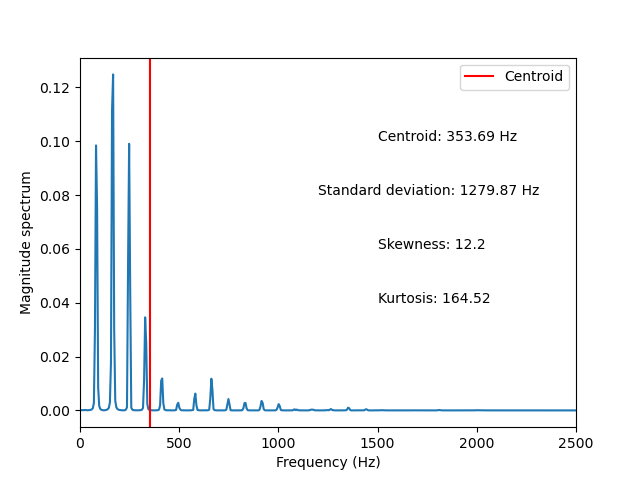

In [7]:
# Load audio and compute stft
audio, rate = util.read_audio(AUDIO_PATH + 'dry.wav')
stft, freq, times = util.get_stft(audio, rate, fft_size=8192)

# Get features of a frame in the sustain part
spectrum = np.abs(stft[:, 100])
centroid = features.spectral_centroid(mag=spectrum, freq=freq)
spread = features.spectral_spread(mag=spectrum, freq=freq)
std = np.sqrt(spread)
skew = features.spectral_skewness(mag=spectrum, freq=freq)
skew = skew/std**3
kurt = features.spectral_kurtosis(mag=spectrum, freq=freq)
kurt = kurt/std**4


# Plotting results
fig, ax = plt.subplots(num=1)
ax.plot(freq, spectrum)
ax.axvline(centroid, color='r', label = 'Centroid')
ax.text(x=1500, y=0.1, s=f'Centroid: {np.round(centroid, 2)[0]} Hz')
ax.text(x=1200, y=0.08, s=f'Standard deviation: {np.round(std, 2)[0]} Hz')
ax.text(x=1500, y=0.06, s=f'Skewness: {np.round(skew, 2)[0]}')
ax.text(x=1500, y=0.04, s=f'Kurtosis: {np.round(kurt, 2)[0]}')
ax.set_ylabel("Magnitude spectrum")
ax.set_xlabel("Frequency (Hz)")
ax.set_xlim(0, 2500)
ax.legend()
plt.show()

### Spectral slope

It represents how much the spectral amplitude decreases. It is obtained by linear regression [2]:

$$\hat{a}(f) = \text{slope}.f + \text{const}$$

$$\text{slope} = \frac{N\sum_k f(k)a(k) - \sum_kf(k)\sum_k a(k)}{N\sum_k f^2(k) - \left(\sum_k f(k)\right)^2}$$

<IPython.core.display.Javascript object>


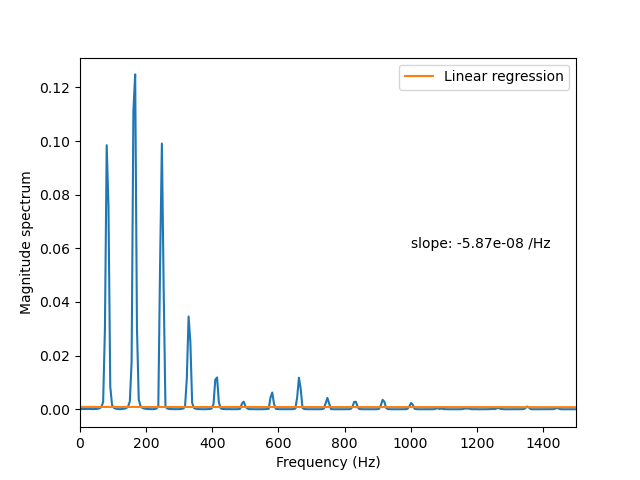

In [8]:
# Get features of a frame in the sustain part
slope = features.spectral_slope(mag=spectrum, freq=freq)
y = freq*slope + np.mean(spectrum) - slope*np.mean(freq)

# Plotting results
fig, ax = plt.subplots(num=2)
ax.plot(freq, spectrum)
ax.plot(freq, y.T, label='Linear regression')
ax.text(x=1000, y=0.06, s=f"slope: {np.round(slope[0][0], 10)} /Hz")
ax.set_ylabel("Magnitude spectrum")
ax.set_xlabel("Frequency (Hz)")
ax.set_xlim(0, 1500)
ax.legend()
plt.show()

### Spectral Roll-off

Limit Frequency so that 95% of the signal energy is contained below that frequency. It is correlated to the harmonic/noise cutting frequency [2].

<IPython.core.display.Javascript object>


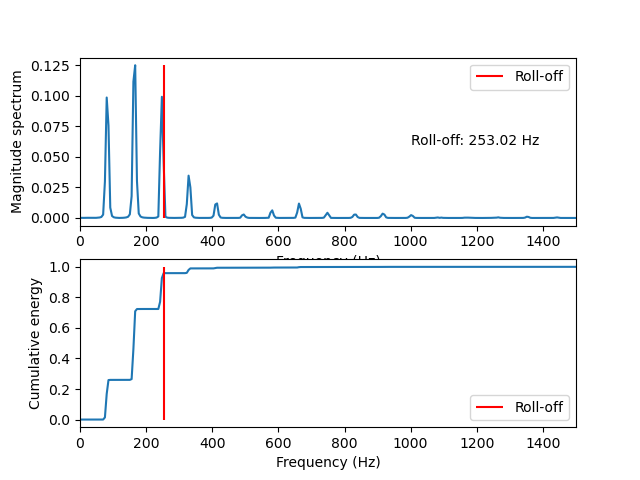

In [9]:
# Get features of a frame in the sustain part
rolloff = features.spectral_rolloff(mag=spectrum, freq=freq)
energy = np.power(spectrum, 2)
cumenergy = np.cumsum(energy)

# Plotting results
fig, axs = plt.subplots(2, num=3)
axs[0].plot(freq, spectrum)
axs[0].vlines(rolloff, 0, np.max(spectrum), color='red', label="Roll-off")
axs[1].plot(freq, cumenergy/np.sum(energy))
axs[1].vlines(rolloff, 0, 1, color='red', label="Roll-off")
axs[0].text(x=1000, y=0.06, s=f"Roll-off: {np.round(rolloff, 2)[0][0]} Hz")
axs[0].set_ylabel("Magnitude spectrum")
axs[0].set_xlabel("Frequency (Hz)")
axs[1].set_ylabel("Cumulative energy")
axs[1].set_xlabel("Frequency (Hz)")
axs[0].set_xlim(0, 1500)
axs[1].set_xlim(0, 1500)
axs[0].legend()
axs[1].legend()
plt.show()

### Spectral flux

Amount of frame-to-frame energy fluctuation in time [3]:

$$ \phi(t) = \sum_{k} \sqrt[1/q]{\left|a_t(k) - a_{t-1}(k)\right|^q} $$

<IPython.core.display.Javascript object>


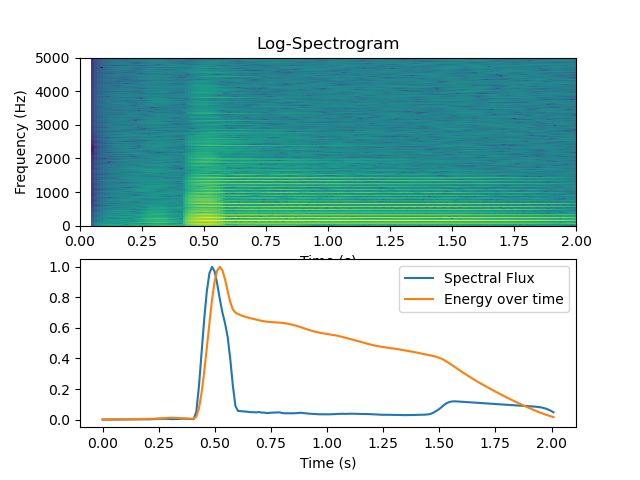

/tmp/ipykernel_309198/2596269053.py:10: RuntimeWarning: divide by zero encountered in log
  ax1.imshow(np.log(mag), interpolation='none', aspect='auto', origin='lower', extent=[0, 2, 0, rate/2])


In [10]:
# Get features of a frame in the sustain part
mag = np.abs(stft)
flux = features.spectral_flux(mag=mag, q_norm=2)
time_energy = np.sum(mag, axis=0)


# Plotting results
fig, axs = plt.subplots(2, num=4)
ax1, ax2 = axs
ax1.imshow(np.log(mag), interpolation='none', aspect='auto', origin='lower', extent=[0, 2, 0, rate/2])
ax1.set_ylim(0, 5000)
ax1.set_title("Log-Spectrogram")
ax1.set_ylabel("Frequency (Hz)")
ax1.set_xlabel("Time (s)")
ax2.plot(times, flux/np.max(flux), label='Spectral Flux')
ax2.plot(times, time_energy/np.max(time_energy), label='Energy over time')
ax2.set_xlabel("Time (s)")
ax2.legend()
plt.show()

### Spectral flatness

Measure of the noisiness of a spectrum [2, 3]. It can be computed on several frequency bands for further precision.

$$ \text{Flatness} = \frac{\text{Geometric mean}}{\text{Arithmetic mean}}$$


/home/alexandre/AutoFX/source/notebooks/../features.py:16: RuntimeWarning: divide by zero encountered in log
  return np.exp(np.mean(np.log(arr)))
/home/alexandre/AutoFX/source/notebooks/../features.py:225: RuntimeWarning: invalid value encountered in float_scalars
  flatness[fr, b] = _geom_mean(arr)/np.mean(arr)


<IPython.core.display.Javascript object>


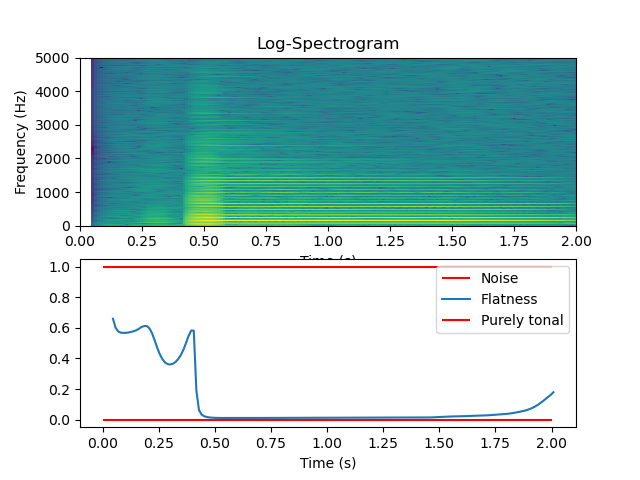

/tmp/ipykernel_309198/190156859.py:6: RuntimeWarning: divide by zero encountered in log
  ax1.imshow(np.log(mag), interpolation='none', aspect='auto', origin='lower', extent=[0, 2, 0, rate/2])


In [11]:
flatness = features.spectral_flatness(mag=mag, rate=rate)

# Plotting results
fig, axs = plt.subplots(2, num=5)
ax1, ax2 = axs
ax1.imshow(np.log(mag), interpolation='none', aspect='auto', origin='lower', extent=[0, 2, 0, rate/2])
ax1.set_ylim(0, 5000)
ax1.set_title("Log-Spectrogram")
ax1.set_ylabel("Frequency (Hz)")
ax1.set_xlabel("Time (s)")
ax2.hlines(1, 0, 2, label='Noise', color='red')
ax2.plot(times, flatness, label='Flatness')
ax2.hlines(0, 0, 2, label='Purely tonal', color='red')
ax2.set_xlabel("Time (s)")
ax2.legend()
plt.show()

## Functionals and training dataset design

We have to turn those arrays of framewise features to scalars to form a vector to feed our classifier.
A __Functional__ is any function mapping an array to a scalar.


References:
-  [1] Stein _et al._, Automatic Detection of audio effects in Guitar and Bass Recordings, AES 2010;
- [2] Jürgens _et al._, Recognizing guitar effects and their parameter settings, DAFx 2020.

### Considered functionals:

- `max`;
- `min`;
- `mean`;
- `std`;
- `skewness`;
- `kurtosis`;

For both the original features and their _high-passed_ version.

To consider the information contained in the __pitch__ (especially relevant for the spectral centroid), pitch-normalized versions of _spectral centroid, spread, skewness and kurtosis_ are also computed.

This yields a final input vector of size 144 (actually 143 because one is all zero) for each soundfile


## Classifiers

Based on those input vectors, we have to use a classification algorithm to recognize effects.
Several options are available.

In [12]:
# Dataloading
dataset = pd.read_csv(DATA_PATH + 'guitar_mono.csv', index_col=0)
subset = dataset.drop(columns=['flux_min'])
target = []
for fx in subset['target_name']:
    target.append(util.idmt_fx2class_number(fx))
data = subset.drop(columns=['target_name'])
# Split into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3)


# Normalize data
## Note that the scaler is fitted on training data and thus has to
## be kept alongside the classifier to be applied to any input.
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Principal Component Analysis for data visualization

Map input vectors to a 2D space for easier visualisation (this is only used for presentation purposes and not for classification)

In [13]:
from sklearn.decomposition import PCA

pca2d = PCA(n_components=2)
pca3d = PCA(n_components=3)
data_2d = pca2d.fit_transform(X_train)
data_3d = pca3d.fit_transform(X_train)

<IPython.core.display.Javascript object>


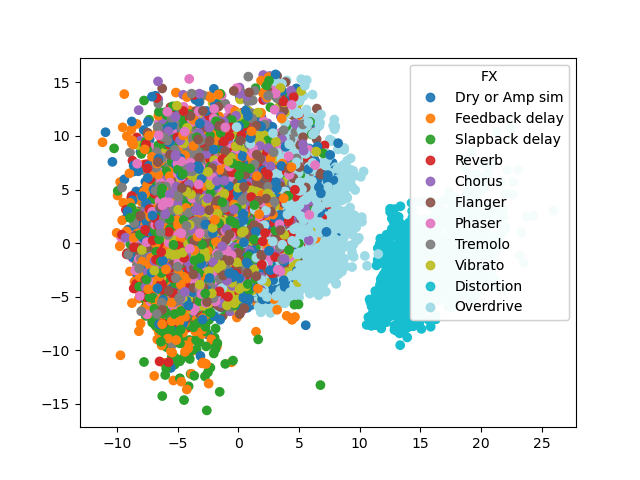

In [14]:
fig, ax = plt.subplots(num=12)
scatter = ax.scatter(data_2d[:, 0], data_2d[:, 1], c=y_train, cmap="tab20")
handles, labels = scatter.legend_elements(prop="colors", alpha=0.9)
legend2 = ax.legend(handles, label_vector(labels), loc="upper right", title="FX")
ax.add_artist(legend2)
plt.show()

<IPython.core.display.Javascript object>


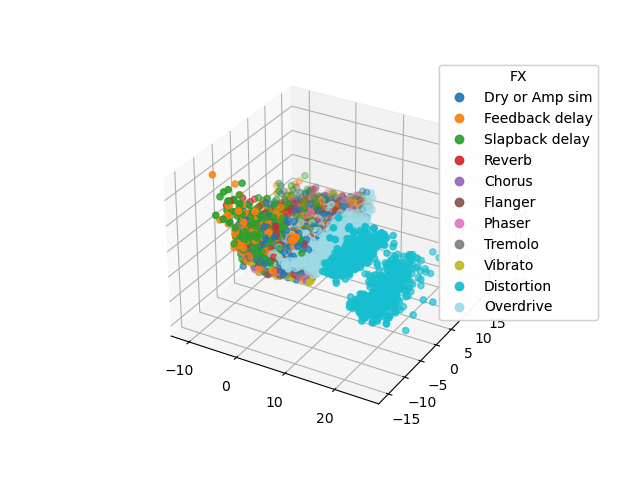

In [15]:
fig = plt.figure()
ax = plt.axes(projection='3d')
scatter = ax.scatter3D(data_3d[:, 0], data_3d[:, 1], data_3d[:, 2], c=y_train, cmap='tab20')
handles, labels = scatter.legend_elements(prop="colors", alpha=0.9)
legend2 = ax.legend(handles, label_vector(labels), loc="upper right", title="FX", bbox_to_anchor=(3/4, 1/2, 1/2, 1/2))
ax.add_artist(legend2)
plt.show()

#### Sidenote: Finding the best parameters to a classifier

Several classification algorithms exist and, for a fair comparison, we should ensure that all results are obtained from classifiers with optimal parameters. 


In `scikit-learn` this is easily done using a `GridSearchCV` with a list of parameter values to test.

### k-Nearest Neighbors

Each new datapoint is assigned to the class that is closest to it according to a number of neighbors and a distance metrics.


![alt text](https://scikit-learn.org/stable/_images/sphx_glr_plot_classification_001.png)


In [16]:
# Define and train the KNeighbors Classifier
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=50, weights='distance')

start = time()
knn_clf.fit(X_train, y_train)
end = time()

knn_time = np.round(end - start, 3)
print("Training took: ", knn_time, 's')

Training took:  0.003 s


Accuracy:  0.657
Precision:  0.693
Recall:  0.656


<IPython.core.display.Javascript object>


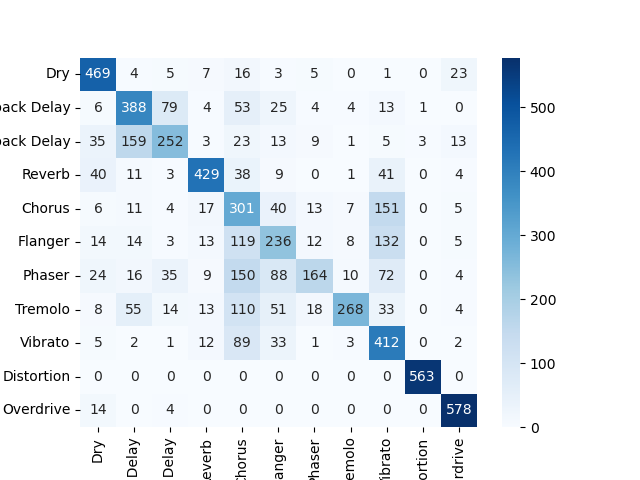

In [17]:
# Test the classifier

y_pred = knn_clf.predict(X_test)

knn_acc = np.round(metrics.accuracy_score(y_test, y_pred), 3)
knn_prec = np.round(np.mean(metrics.precision_score(y_test, y_pred, average=None)), 3)
knn_rec = np.round(np.mean(metrics.recall_score(y_test, y_pred, average=None)), 3)
print("Accuracy: ", knn_acc)
print("Precision: ", knn_prec)
print("Recall: ", knn_rec)

matrix = metrics.confusion_matrix(y_test, y_pred)
make_confusion_matrix(matrix, group_names=CLASSES, categories=CLASSES, percent=False)

### Perceptron

A perceptron is a simple feed-forward neural network that can be used as a classifier. It can have one or several hidden layers, as many output neurons as necessary and, most importantly, it can end with a __softmax output layer__ to return probabilities of belonging to classes instead of binary _True/False_ answers.

![Feed-forward network](https://upload.wikimedia.org/wikipedia/commons/8/82/FeedForwardNN.png)

[Source](https://commons.wikimedia.org/w/index.php?curid=58352970)

In [18]:
# Define and train a simple Perceptron classifier
from sklearn.linear_model import Perceptron
clf = Perceptron(fit_intercept=True, alpha=1e-4, eta0=0.1, penalty='elasticnet', tol=0.01, l1_ratio=1)

print("Training...")
start = time()
clf.fit(X_train, y_train)
end = time()

perc_time = np.round(end - start, 3)
print("Training took: ", perc_time)

Training...
Training took:  1.104


Accuracy:  0.793
Precision:  0.815
Recall:  0.792


<IPython.core.display.Javascript object>


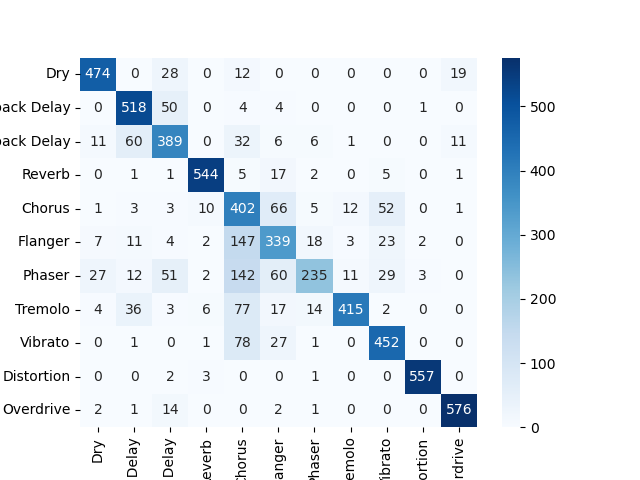

In [19]:
# Error measures

y_pred = clf.predict(X_test)

perc_acc = np.round(metrics.accuracy_score(y_test, y_pred), 3)
perc_prec = np.round(np.mean(metrics.precision_score(y_test, y_pred, average=None)), 3)
perc_rec = np.round(np.mean(metrics.recall_score(y_test, y_pred, average=None)), 3)
print("Accuracy: ", perc_acc)
print("Precision: ", perc_prec)
print("Recall: ", perc_rec)

matrix = metrics.confusion_matrix(y_test, y_pred)
make_confusion_matrix(matrix, group_names=CLASSES, categories=CLASSES, percent=False)

In [20]:
# Define and train a Multi-Layer Perceptron classifier
from sklearn.neural_network import MLPClassifier
clf_mlp = MLPClassifier(activation='identity', solver='adam', hidden_layer_sizes=100,
                    alpha=1e-5, learning_rate_init=0.001, beta_1=0.9, beta_2=0.8)

print("Training...")
start = time()
clf_mlp.fit(X_train, y_train)
end = time()

mlp_time = np.round(end - start, 3)
print("Training took: ", mlp_time)

Training...
Training took:  5.242


Accuracy:  0.902
Precision:  0.901
Recall:  0.902


<IPython.core.display.Javascript object>


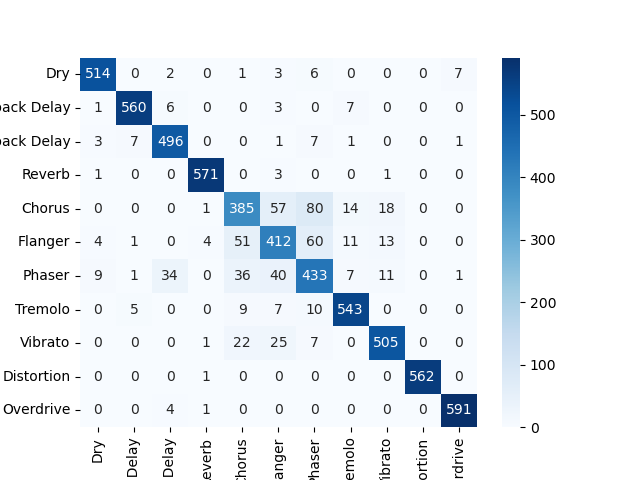

In [21]:
# Error measures

y_pred = clf_mlp.predict(X_test)

mlp_acc = np.round(metrics.accuracy_score(y_test, y_pred), 3)
mlp_prec = np.round(np.mean(metrics.precision_score(y_test, y_pred, average=None)), 3)
mlp_rec = np.round(np.mean(metrics.recall_score(y_test, y_pred, average=None)), 3)
print("Accuracy: ", mlp_acc)
print("Precision: ", mlp_prec)
print("Recall: ", mlp_rec)

matrix = metrics.confusion_matrix(y_test, y_pred)
make_confusion_matrix(matrix, group_names=CLASSES, categories=CLASSES, percent=False)

### Support Vector Machines (SVM)

Algorithm to find the optimal hyperplane to separate data into clusters.

![Non-optimal separation](https://miro.medium.com/max/600/0*9jEWNXTAao7phK-5.png)![Optimal hyperplane](https://miro.medium.com/max/600/0*0o8xIA4k3gXUDCFU.png)
[Source](https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47)

The algorithm can be used to classify data that is not _linearly separable_ using different __kernel functions__.

![Kernel trick](https://upload.wikimedia.org/wikipedia/commons/thumb/b/ba/Separatrice_non_lineaire.svg/1280px-Separatrice_non_lineaire.svg.png)
[Source](https://commons.wikimedia.org/w/index.php?curid=3325499)

In [22]:
# Define and fit the algorithm
from sklearn import svm
clf_svm = svm.SVC(kernel='linear', C=1)

print("Training...")
start = time()
clf_svm.fit(X_train, y_train)
end = time()

svm_time = np.round(end - start, 3)
print("Training took: ", svm_time)

Training...
Training took:  3.675


Accuracy:  0.92
Precision:  0.921
Recall:  0.92


<IPython.core.display.Javascript object>


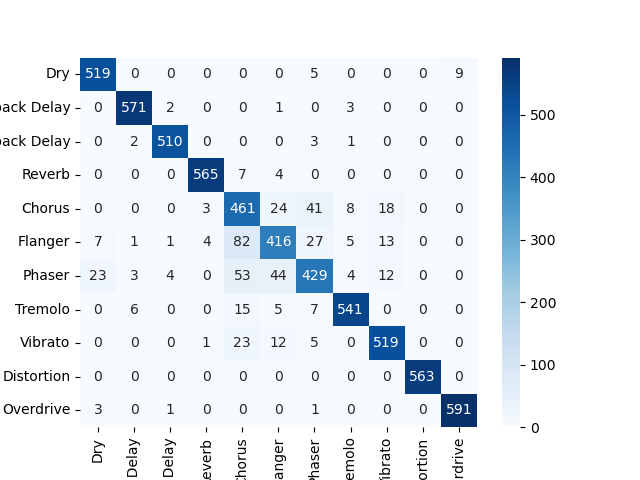

In [23]:
y_pred = clf_svm.predict(X_test)

svm_acc = np.round(metrics.accuracy_score(y_test, y_pred), 3)
svm_prec = np.round(np.mean(metrics.precision_score(y_test, y_pred, average=None)), 3)
svm_rec = np.round(np.mean(metrics.recall_score(y_test, y_pred, average=None)), 3)
print("Accuracy: ", svm_acc)
print("Precision: ", svm_prec)
print("Recall: ", svm_rec)

matrix = metrics.confusion_matrix(y_test, y_pred)
make_confusion_matrix(matrix, group_names=CLASSES, categories=CLASSES, percent=False)

### Summary results

|| kNN | Perceptron | MLP | SVM | [1] | [2] |
| :- | :-: | :-: | :-: | :-: | :-: | :-: | 
| Accuracy | {{ knn_acc }} | {{ perc_acc }} | {{ mlp_acc }} | {{ svm_acc }} | 0.977 | 0.949 |
| Precision | {{ knn_prec }} | {{ perc_prec }} | {{ mlp_prec }} | {{ svm_prec }} | ? | ? |
| Recall | {{ knn_rec }} | {{ perc_rec }} | {{ mlp_rec }} | {{ svm_rec }} | ? | ? |
| Training time | {{ knn_time }} | {{ perc_time }} | {{ mlp_time }} | {{ svm_time}} | ? | ? 

## Does it generalize well?

Good results are obtained for classification of in-domain sounds, _i.e._ sounds produced in the same way as the training dataset.
However, we expect the classifier to recognize effects regardless of the origin of the sound.

#### Bass Monophonic sounds

In [24]:
dataset = pd.read_csv(DATA_PATH + 'bass_mono.csv', index_col=0)
subset = dataset.drop(columns=['flux_min'])
target = []
for fx in subset['target_name']:
    target.append(util.idmt_fx2class_number(fx))
data = subset.drop(columns=['target_name'])
bass_mono = scaler.transform(data)

##### Multi-Layer Perceptron

<IPython.core.display.Javascript object>


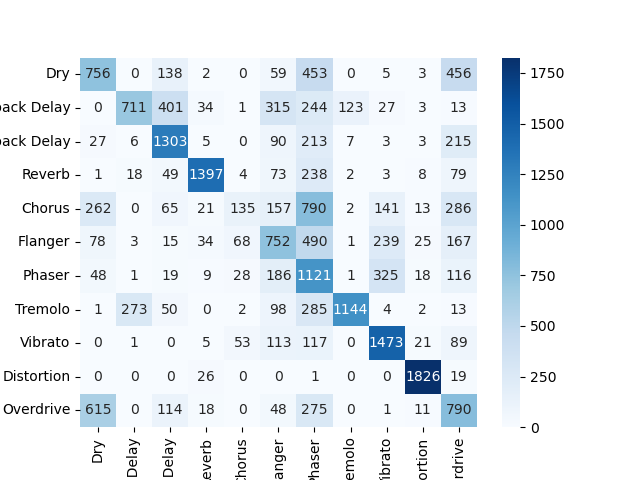

In [25]:
y_pred = clf_mlp.predict(bass_mono)
matrix = metrics.confusion_matrix(target, y_pred)
make_confusion_matrix(matrix, group_names=CLASSES, categories=CLASSES, percent=False)

##### Support Vectors Machine

<IPython.core.display.Javascript object>


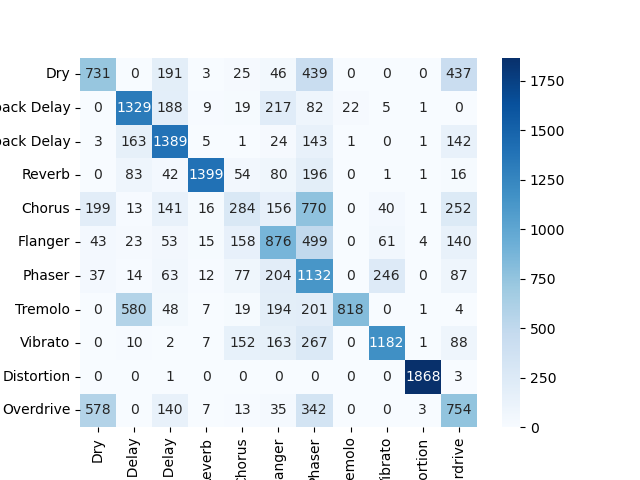

In [26]:
y_pred = clf_svm.predict(bass_mono)
matrix = metrics.confusion_matrix(target, y_pred)
make_confusion_matrix(matrix, group_names=CLASSES, categories=CLASSES, percent=False)

#### Guitar Polyphonic sounds

In [27]:
dataset = pd.read_csv(DATA_PATH + 'guitar_poly.csv', index_col=0)
subset = dataset.drop(columns=['flux_min'])
target = []
for fx in subset['target_name']:
    target.append(util.idmt_fx2class_number(fx))
data = subset.drop(columns=['target_name'])
guitar_poly = scaler.transform(data)

##### Multi-Layer Perceptron

<IPython.core.display.Javascript object>


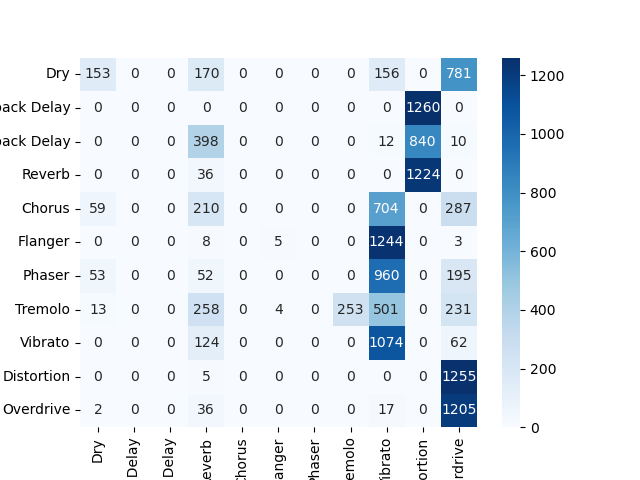

In [28]:
y_pred = clf_mlp.predict(guitar_poly)
matrix = metrics.confusion_matrix(target, y_pred)
make_confusion_matrix(matrix, group_names=CLASSES, categories=CLASSES, percent=False)

##### Support Vectors Machine

<IPython.core.display.Javascript object>


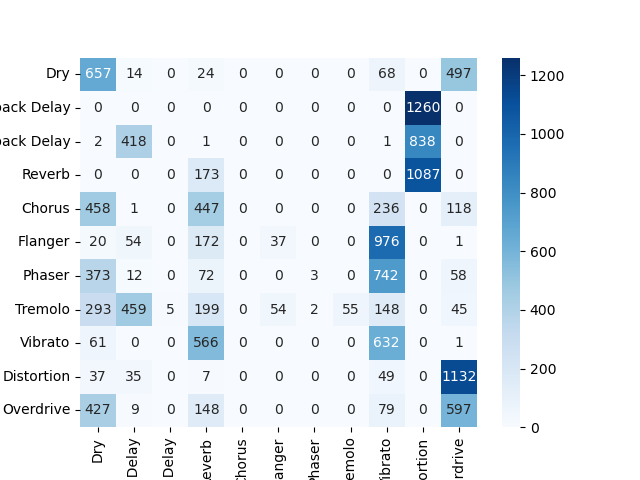

In [29]:
y_pred = clf_svm.predict(guitar_poly)
matrix = metrics.confusion_matrix(target, y_pred)
make_confusion_matrix(matrix, group_names=CLASSES, categories=CLASSES, percent=False)

### Train on Full dataset

In [30]:
dataset = pd.read_csv(DATA_PATH + 'full_dataset.csv', index_col=0)
subset = dataset.drop(columns=['flux_min'])
target = []
for fx in subset['target_name']:
    target.append(util.idmt_fx2class_number(fx))
data = subset.drop(columns=['target_name'])

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3)

scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#### SVM

In [42]:
clf_svm = svm.SVC(kernel='rbf', C=1000, gamma=0.001)

print("Training...")
start = time()
clf_svm.fit(X_train, y_train)
end = time()

print("Training took: ", end-start)

Training...
Training took:  146.57410383224487


Accuracy:  0.919
Precision:  0.92
Recall:  0.918


<IPython.core.display.Javascript object>


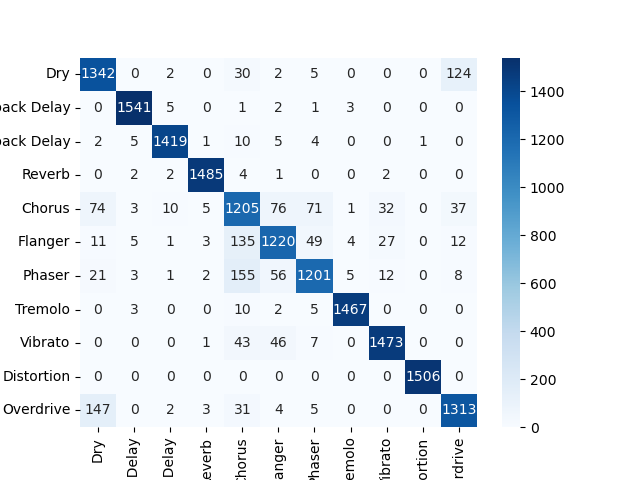

In [43]:
y_pred = clf_svm.predict(X_test)
svm_acc = np.round(metrics.accuracy_score(y_test, y_pred), 3)
svm_prec = np.round(np.mean(metrics.precision_score(y_test, y_pred, average=None)), 3)
svm_rec = np.round(np.mean(metrics.recall_score(y_test, y_pred, average=None)), 3)
print("Accuracy: ", svm_acc)
print("Precision: ", svm_prec)
print("Recall: ", svm_rec)
matrix = metrics.confusion_matrix(y_test, y_pred)
make_confusion_matrix(matrix, group_names=CLASSES, categories=CLASSES, percent=False)

#### MLP

In [44]:
clf_mlp = MLPClassifier(activation='logistic', solver='adam', max_iter=500)

print("Training...")
start = time()
clf_mlp.fit(X_train, y_train)
end = time()

print("Training took: ", end-start)

Training...
Training took:  452.1067576408386


/home/alexandre/miniconda3/envs/autoFX3-10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy:  0.912
Precision:  0.912
Recall:  0.912


<IPython.core.display.Javascript object>


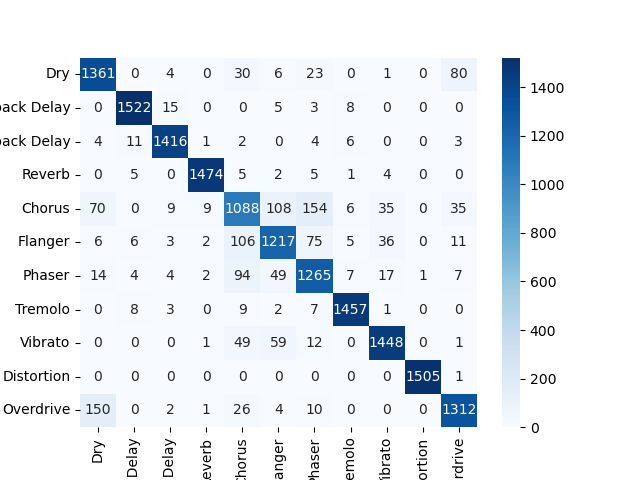

In [45]:
y_pred = clf_mlp.predict(X_test)
svm_acc = np.round(metrics.accuracy_score(y_test, y_pred), 3)
svm_prec = np.round(np.mean(metrics.precision_score(y_test, y_pred, average=None)), 3)
svm_rec = np.round(np.mean(metrics.recall_score(y_test, y_pred, average=None)), 3)
print("Accuracy: ", svm_acc)
print("Precision: ", svm_prec)
print("Recall: ", svm_rec)
matrix = metrics.confusion_matrix(y_test, y_pred)
make_confusion_matrix(matrix, group_names=CLASSES, categories=CLASSES, percent=False)

#### Guitar sounds with custom Distortion effect

In [41]:
dataset = pd.read_csv(DATA_PATH + 'distortion_continuous.csv', index_col=0)
dataset = dataset.drop(columns=['flux_min', 'target_name'])
target = [util.idmt_fx2class_number('Distortion')]*dataset.shape[0]
data = scaler.transform(dataset)

Accuracy:  0.315
Precision:  0.143
Recall:  0.045


/home/alexandre/miniconda3/envs/autoFX3-10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<IPython.core.display.Javascript object>


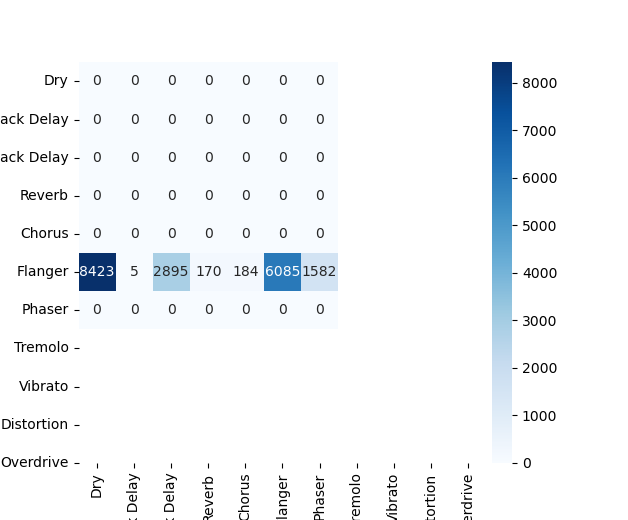

In [46]:
y_test = target
y_pred = clf_svm.predict(data)
svm_acc = np.round(metrics.accuracy_score(y_test, y_pred), 3)
svm_prec = np.round(np.mean(metrics.precision_score(y_test, y_pred, average=None)), 3)
svm_rec = np.round(np.mean(metrics.recall_score(y_test, y_pred, average=None)), 3)
print("Accuracy: ", svm_acc)
print("Precision: ", svm_prec)
print("Recall: ", svm_rec)
matrix = metrics.confusion_matrix(y_test, y_pred)
make_confusion_matrix(matrix, group_names=CLASSES, categories=CLASSES, percent=False)

Accuracy:  0.731
Precision:  0.1
Recall:  0.073


/home/alexandre/miniconda3/envs/autoFX3-10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<IPython.core.display.Javascript object>


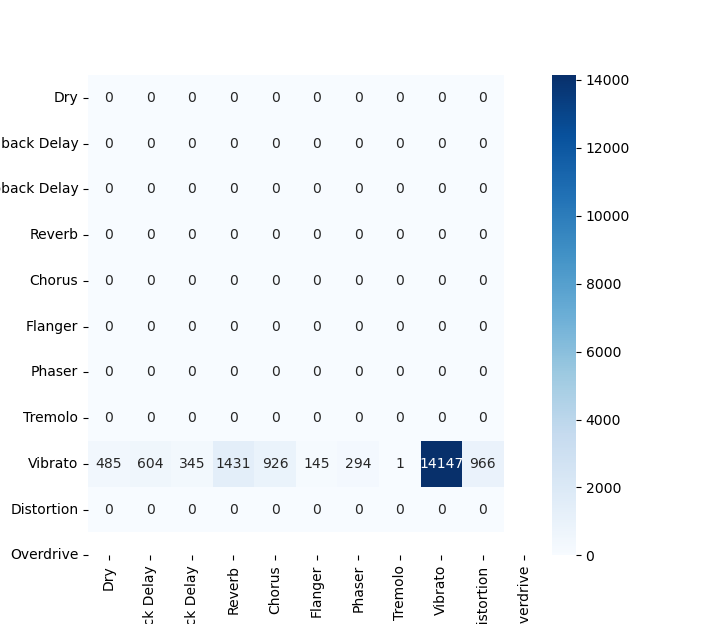

In [47]:
y_test = target
y_pred = clf_mlp.predict(data)
svm_acc = np.round(metrics.accuracy_score(y_test, y_pred), 3)
svm_prec = np.round(np.mean(metrics.precision_score(y_test, y_pred, average=None)), 3)
svm_rec = np.round(np.mean(metrics.recall_score(y_test, y_pred, average=None)), 3)
print("Accuracy: ", svm_acc)
print("Precision: ", svm_prec)
print("Recall: ", svm_rec)
matrix = metrics.confusion_matrix(y_test, y_pred)
make_confusion_matrix(matrix, group_names=CLASSES, categories=CLASSES, percent=False)

In [53]:
dataset = pd.read_csv(DATA_PATH + 'chorus.csv', index_col=0)
dataset = dataset.drop(columns=['flux_min', 'target_name'])
target = [util.idmt_fx2class_number('Chorus')]*dataset.shape[0]
data = scaler.transform(dataset)

Accuracy:  0.33
Precision:  0.125
Recall:  0.041


/home/alexandre/miniconda3/envs/autoFX3-10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<IPython.core.display.Javascript object>


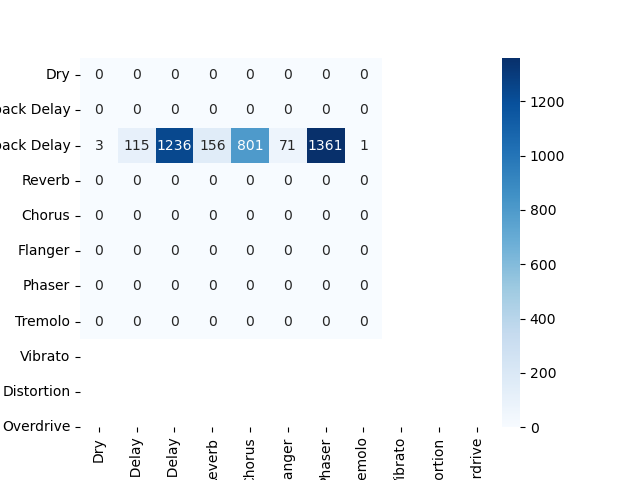

In [54]:
y_test = target
y_pred = clf_svm.predict(data)
svm_acc = np.round(metrics.accuracy_score(y_test, y_pred), 3)
svm_prec = np.round(np.mean(metrics.precision_score(y_test, y_pred, average=None)), 3)
svm_rec = np.round(np.mean(metrics.recall_score(y_test, y_pred, average=None)), 3)
print("Accuracy: ", svm_acc)
print("Precision: ", svm_prec)
print("Recall: ", svm_rec)
matrix = metrics.confusion_matrix(y_test, y_pred)
make_confusion_matrix(matrix, group_names=CLASSES, categories=CLASSES, percent=False)

Accuracy:  0.305
Precision:  0.1
Recall:  0.031


/home/alexandre/miniconda3/envs/autoFX3-10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_309198/1788784929.py:91: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=figsize)


<IPython.core.display.Javascript object>


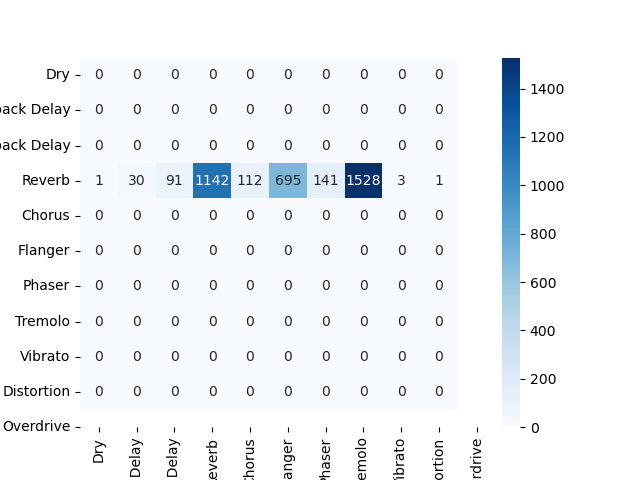

In [55]:
y_test = target
y_pred = clf_mlp.predict(data)
svm_acc = np.round(metrics.accuracy_score(y_test, y_pred), 3)
svm_prec = np.round(np.mean(metrics.precision_score(y_test, y_pred, average=None)), 3)
svm_rec = np.round(np.mean(metrics.recall_score(y_test, y_pred, average=None)), 3)
print("Accuracy: ", svm_acc)
print("Precision: ", svm_prec)
print("Recall: ", svm_rec)
matrix = metrics.confusion_matrix(y_test, y_pred)
make_confusion_matrix(matrix, group_names=CLASSES, categories=CLASSES, percent=False)

In [37]:
# Non-guitar sound with other FX